Convolutional Neural Network (CNN) Autoencoder
======

In [1]:
import sys

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from glob import glob
import numpy as np

from plot_mel import * 

from tqdm import tqdm

from timeit import default_timer as timer

In [2]:
device = "cpu"
DEBUGGING = True #If True it limits the number of data you import in the load_dataset function

Data Loading
-------------------


In [3]:
# This function will take care of the dataloading
def load_dataset(folder,normalize,total_number_to_import=1965):
    dataset = []
    scaler = MinMaxScaler()
    
    count = 0
    for mel_spec in folder:
        data = np.load(mel_spec)
        if normalize is True:
            data = scaler.fit_transform(data)
        dataset.append(torch.tensor(data))
        count += 1
        
        if DEBUGGING:
            if count == total_number_to_import: 
                print(f"NE STAI USANDO SOLO {count}")
                break
            
    return dataset



### Use this to import MELS and convert them to tensors

Otherwise just load the tensors


#### Pre - training data

Low-pass filtered data (500Hz) is used to pre-train the model.
Every pre-train uses only one language at a time. The languages we chose for the different pre-trainings are:

* Spanish
* English
* Japanese

In [ ]:
# Enter the path where you keep your filtered spectrograms
folder = glob("../Dataset/Filtered spectrograms/ita_filtered_mel_spectrograms/*")

filtered_data = load_dataset(folder,normalize=True)

# Concatenates a sequence of tensors along a new dimension.
# All tensors need to be of the same size.
filtered_data = torch.stack(filtered_data,dim=0)

Just load the tensors if you already have them.

In [4]:
filtered_data = torch.load("../Dataset/Filtered spectrograms/filtered_spa_tensor.pt")

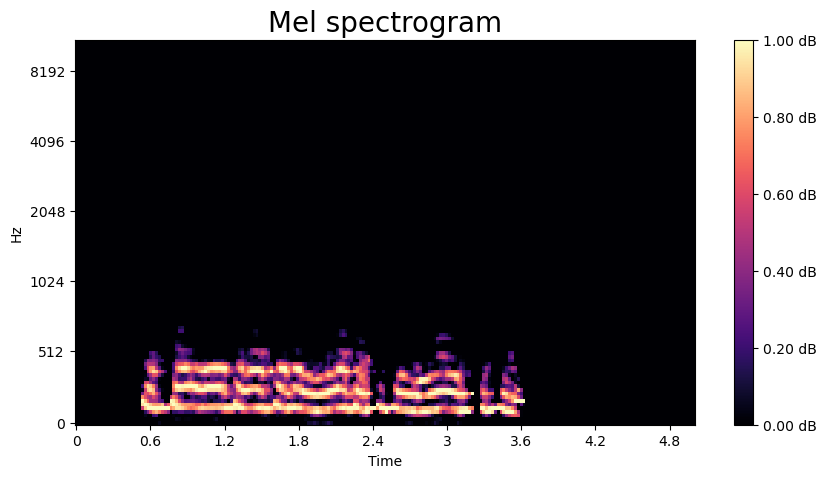

In [5]:
#An example
plot_mel(filtered_data[0])

In [6]:
# Train test split

batch_size = 100
train_data, test_data = train_test_split(filtered_data, test_size=0.2, random_state=42)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


Autoencoder Definition
-----------------------
We use a **Convolutional Encoder - Decoder**, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [7]:
class Autoencoder(nn.Module):
    def __init__(self,encoded_space_dim):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=(4, 4),stride=2, padding=1),
            
            nn.Conv2d(in_channels=32,out_channels= 64, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=(4, 4),stride=2, padding=1),
            
            nn.Conv2d(in_channels=64,out_channels= 4, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(4),
            nn.ReLU(),
          
        )


         ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1) 

        ### Linear section
        ## This is the actual ENCODED / LATENT SPACE that will be extracted and studied
        self.encoder_lin = nn.Sequential(
            nn.Linear(4*32*54, encoded_space_dim), #input dimension is Number of out_channels from last CNN layer, rowXcolumn.
                                                    #if you change some CNN parameter rowXcolumn wil change too
            nn.ReLU(True),
            
        )
        #Decoding part
        #This is the reverse step-by-step of what comes before
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 4*32*54), #out put dim is the same of input dim of encoder_lin. If smth changes, you should change this and the following too
            nn.ReLU(True),
            
        )

        self.unflatten = nn.Unflatten(dim=1,
        unflattened_size=(4, 32, 54)) #depends on output of preceeding linear layer







        # Decoder
        ## If some of the preceeding parameres are changed, you need to tune scale_factor accordingly
        #BatchNorm2d takes out_channel as input
        self.decoder = nn.Sequential(
           
            nn.ConvTranspose2d(in_channels=4, out_channels=64, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
           
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1,padding=1, output_padding=0),
            nn.BatchNorm2d(1),
            nn.ReLU())
      
            
            
            
    def forward(self, x):
        #dataset requires to convert to double before doing anything. This line can be removed
        x = x.double()
        
        x = self.encoder(x)

        x = self.flatten(x)

        latent_space = self.encoder_lin(x)
        
        x = self.decoder_lin(latent_space)
    
        x = self.unflatten(x)
       
        x = self.decoder(x)

        return x 

# Create an instance of the autoencoder
# Here the encoded space dimension can be tuned 
autoencoder = Autoencoder(encoded_space_dim=3000).double()

# Print the architecture
print(autoencoder)


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(4, 4), stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(4, 4), stride=2, padding=1, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=6912, out_features=3000, bias=True)
    (1): ReLU(inplace=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=3000, out_features=6

Pre - Train Autoencoder
--------

##### Parameter Settings


In [ ]:
num_epochs = 1
learning_rate = 1e-3

In [ ]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch in tqdm(train_dataloader):
        
        
        #Unsqueeze adds an additional dimension. This is needed for the CNN wants the channel dimension to be explicit
        image_batch = image_batch.unsqueeze(1)
        
        image_batch = image_batch.to(device)
        
        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)
        
        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

### Save / Load pre-trained model

In [8]:
autoencoder.load_state_dict(torch.load("../Final models state dictionaries/Autoencoder model states/spa_pretrain.pt"))

<All keys matched successfully>

Plot Training Curve
--------------------

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

Evaluate on the Test Set
-------------------------

In [ ]:
# set to evaluation mode
autoencoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch in test_dataloader:

    with torch.no_grad():
        
        image_batch = image_batch.unsqueeze(1)
        
        image_batch = image_batch.to(device).float()

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

# Full training


This is done by choosing only one language. We picked spanish.


## Load full dataset

These data have already been normalized

In [9]:
spa = torch.load("../Dataset/Unfiltered tensors/spa_unfiltered.pt")

Full training with spanish only


In [10]:
num_epochs = 5
batch_size = 100
learning_rate = 1e-3
loss_threshold = .02

In [11]:
# Dividi l'array 'data' in train set e test set
train_data, test_data = train_test_split(spa, test_size=0.2, random_state=42)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

 Let's go with the full training

In [12]:
train_data.shape

torch.Size([12580, 128, 216])

We are interested to see the effect of different pre-trainings in the time required to reach a certain score-threshold.
When the threshold is reached, training stops.


In [ ]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
autoencoder.train()

train_loss_avg = []

backup_train_loss_diego = []

print('Training ...')
THRESHOLD_REACHED = False
start_timer = timer()
for epoch in range(num_epochs):
    
    if THRESHOLD_REACHED: break
    
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch in tqdm(train_dataloader):
        
        
       #Unsqueeze adds an additional dimension. This is needed for the CNN wants the channel dimension to be explicit
        image_batch = image_batch.unsqueeze(1)
        
        image_batch = image_batch.to(device)
        
        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch).float()
        
        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
        
        if train_loss_avg[-1] <= loss_threshold:
            end_timer = timer() - start_timer
            print("THRESHOLD REACHED!")
            THRESHOLD_REACHED = True
            break
        
    
    backup_train_loss_diego.append(loss.item())
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    

print("End train",end_timer)

In [ ]:
end_timer

In [ ]:
# Save the model

torch.save(autoencoder.state_dict(),"../saved_models/final_results/onlyFULL.pt")


In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

Evaluate on the Test Set
-------------------------

In [ ]:
# set to evaluation mode
autoencoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch in test_dataloader:

    with torch.no_grad():
        
        image_batch = image_batch.unsqueeze(1)
        
        image_batch = image_batch.to(device).float()

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

Visualize Reconstructions
--------------------------

In [ ]:
import librosa 
def plot_mel(mel):
    if type(mel)==str:
        swag=torch.load(mel)
        swag=swag.detach().numpy()
    else: swag=mel.detach().numpy()
    fig, ax = plt.subplots(figsize=(10, 5))
    # Plot the mel spectogram
    img = librosa.display.specshow(swag,
                              x_axis='time',
                              y_axis='mel',  #scale can be also mel
                              ax=ax)
    ax.set_title('Test data 0 - Reconstruc', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f dB')
    plt.show()

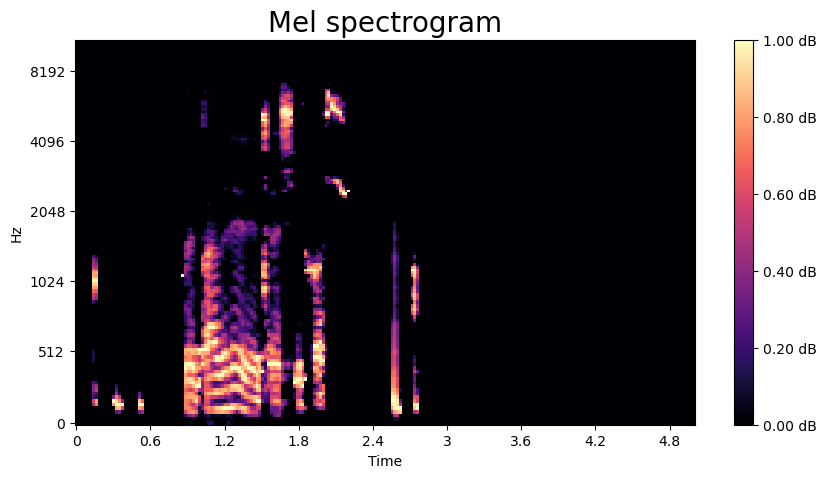

In [13]:
plot_mel(test_data[3])

Encoded shape: torch.Size([128, 216])


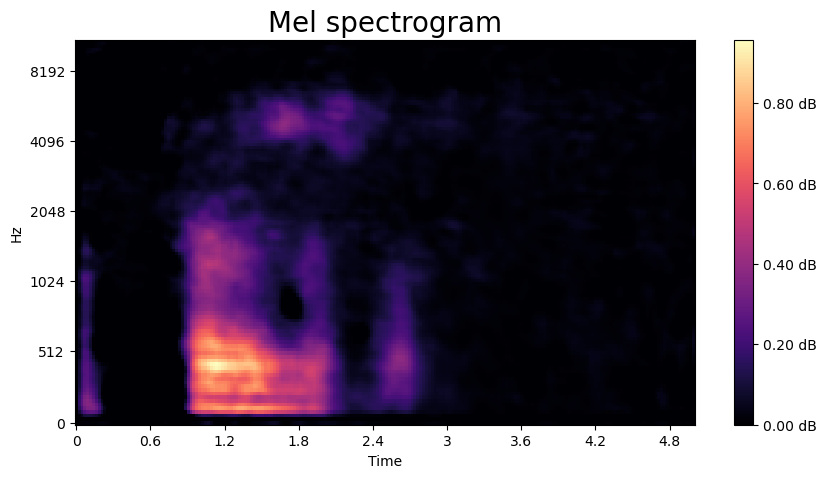

In [14]:
encoded = autoencoder(test_data[3].unsqueeze(0).unsqueeze(1)).squeeze(0).squeeze(0)
print("Encoded shape:",encoded.shape)
plot_mel(encoded)

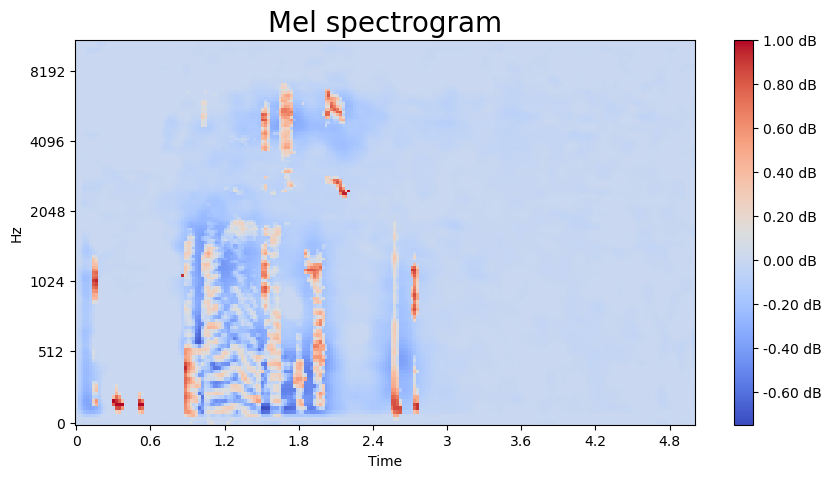

In [16]:
#Residuals
plot_mel((- encoded + test_data[3]))